In [8]:
### Copyright (c) 2022[Yizi Zhao]. All rights reserved.
### Licensed under the MIT License.
### import necessary packages
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
import os       

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

In [2]:
import os
os.makedirs("../../results/GC-prognosis-model/Figures", exist_ok=True)
os.makedirs("../../results/GC-prognosis-model/Saved-model", exist_ok=True)

In [3]:
##### settings #####
random_state=20 # control reproducibility 
n_estimators=1000 # fit a Random Survival Forest comprising 1000 trees
min_samples_split=10 # The minimum number of samples required to split an internal node
min_samples_leaf=15 # The minimum number of samples required to be at a leaf node. 
max_features="sqrt" #The number of features to consider when looking for the best split,If “sqrt”, then max_features=sqrt(n_features)
n_jobs=-1 #The number of jobs to run in parallel for both fit and predict.-1 means using all processors.

In [4]:
Xtrain = pd.read_excel('../../data/GC-prognosis-model/Xtrain.xlsx',index_col=0)
ytrain = pd.read_excel('../../data/GC-prognosis-model/ytrain.xlsx',index_col=0)
Xtest = pd.read_excel('../../data/GC-prognosis-model/Xtest.xlsx',index_col=0)
ytest = pd.read_excel('../../data/GC-prognosis-model/ytest.xlsx',index_col=0)

Xtrain_sample=Xtrain["Sample"]
Xtrain = Xtrain.drop(["Sample"],axis=1)
ytrain = ytrain.drop(["Sample"],axis=1)
Xtest_sample=Xtest["Sample"]
Xtest = Xtest.drop(["Sample"],axis=1)
ytest = ytest.drop(["Sample"],axis=1)

y_train=np.array(ytrain)
y_test=np.array(ytest)
print("train test info:")
print("train, survival-death", np.unique(y_train[:,1],return_counts=True))
print("test, survival-death", np.unique(y_test[:,1],return_counts=True))

train test info:
train, survival-death (array([0, 1]), array([97, 24]))
test, survival-death (array([0, 1]), array([50, 10]))


In [5]:
ytrain=pd.DataFrame(ytrain)
ytrain.columns=["ST","State"]
ytrain.loc[:,"State"]=ytrain.loc[:,"State"].astype(bool)
data=np.zeros(len(ytrain),dtype={'names':('cens','time'),'formats':('?','<f8')})
data['cens']=ytrain.loc[:,"State"]
data['time']=ytrain.loc[:,"ST"]
ytrain=data

ytest=pd.DataFrame(ytest)
ytest.columns=["ST","State"]
ytest.loc[:,"State"]=ytest.loc[:,"State"].astype(bool)
data=np.zeros(len(ytest),dtype={'names':('cens','time'),'formats':('?','<f8')})
data['cens']=ytest.loc[:,"State"]
data['time']=ytest.loc[:,"ST"]
ytest=data

In [6]:
# fit a Random Surival Forest model with all metabolites
rsf = RandomSurvivalForest(n_estimators=n_estimators,
                          min_samples_split=min_samples_split,
                          min_samples_leaf=min_samples_leaf,
                          max_features=max_features,
                          n_jobs=n_jobs,
                          random_state=random_state)
rsf.fit(Xtrain,ytrain)

# using all metabolites as feature,and get a concordance index of 0.660458 in testing data
print('training data c-index: %f' % rsf.score(Xtrain,ytrain))
print('testing data c-index: %f' % rsf.score(Xtest,ytest))

training data c-index: 0.963754
testing data c-index: 0.668737


In [11]:
# permutation-based Feature Importance
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(Xtest, ytest)
weights=eli5.show_weights(perm, feature_names=Xtrain.columns.tolist())

In [12]:
# sort feature_importances in descending order by weight
feature_importances=pd.DataFrame(perm.feature_importances_)
feature_importances.index=Xtrain.columns.tolist()
feature_importances.columns=["Weight"]
std=pd.DataFrame(perm.feature_importances_std_)
std.index=Xtrain.columns.tolist()
std.columns=["std"]
feature_importances=pd.concat([feature_importances,std],axis=1)
feature_importances.sort_values(by="Weight",ascending=False,inplace=True)
feature_importances

Weight       std
SDMA-ADMA_pos-140                 0.056039  0.037834
Thymine_pos-150                   0.034783  0.014683
Neopterin_pos-117                 0.025259  0.015312
Uridine_neg-088                   0.015597  0.012257
Hydroxyproline_pos-095            0.013803  0.005691
...                                    ...       ...
Glyceric acid_neg-046            -0.005245  0.011286
3-Phenyllactic acid_neg-009      -0.006487  0.007087
Indole-3-carboxylic acid_neg-052 -0.009662  0.009672
Carnitine-C3_pos-052             -0.014493  0.011761
GSSG_pos-086                     -0.016563  0.011440

[147 rows x 2 columns]

In [13]:
### Verification indicates that the model rebuilt after selecting the top few metabolites based on feature importance performs the best in terms of overall performance.
test_c_index=[]
train_c_index=[]
times=[]
for i in range(1,len(feature_importances)+1):
    sel_feature=feature_importances.iloc[0:i].index.tolist()
    Xtrain_sel=Xtrain.loc[:,sel_feature]
    Xtest_sel=Xtest.loc[:,sel_feature]
    rsf_sel = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
    rsf_sel.fit(Xtrain_sel,ytrain)
    train_c_index.append(rsf_sel.score(Xtrain_sel,ytrain))
    test_c_index.append(rsf_sel.score(Xtest_sel,ytest))
    times.append(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [14]:
# Parameter optimization reveals that the best model prediction performance is achieved when the top 28 features are selected to rebuild the model
sel_feature=feature_importances.iloc[0:28].index.tolist()
### select the top 28 VIMP(feature importance) of unique metabolics as feature to train a new model
Xtrain_sel=Xtrain.loc[:,sel_feature]
Xtest_sel=Xtest.loc[:,sel_feature]



In [15]:
rsf_sel = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf_sel.fit(Xtrain_sel,ytrain)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [16]:
### using the top 12 VIMP of unique metabolics as feature,and get a concordance index of 0.916221 in testing data
print('training data c-index: %f' % rsf_sel.score(Xtrain_sel,ytrain))
print('testing data c-index: %f' % rsf_sel.score(Xtest_sel,ytest))

training data c-index: 0.904148
testing data c-index: 0.826087


In [17]:
perm_sel = PermutationImportance(rsf_sel, n_iter=15, random_state=random_state)
perm_sel.fit(Xtest_sel, ytest)
eli5.show_weights(perm_sel, feature_names=Xtrain_sel.columns.tolist())


In [18]:
# sort feature_importances in descending order by weight
feature_importances_sel=pd.DataFrame(perm_sel.feature_importances_)
feature_importances_sel.index=Xtrain_sel.columns.tolist()
feature_importances_sel.columns=["Weight"]
std_sel=pd.DataFrame(perm_sel.feature_importances_std_)
std_sel.index=Xtrain_sel.columns.tolist()
std_sel.columns=["std"]
feature_importances_sel=pd.concat([feature_importances_sel,std_sel],axis=1)
feature_importances_sel.sort_values(by="Weight",ascending=False,inplace=True)
feature_importances_sel.to_excel('../../results/GC-prognosis-model/GC-prognosis-model-feature-importances.xlsx')

In [19]:
risk_score=pd.Series(rsf_sel.predict(Xtest_sel))
cens=ytest["cens"].astype('int')
time=ytest['time'].astype('float')
risk=pd.DataFrame({"risk_score":risk_score,"OS":time,"State":cens,"Sample":Xtest_sample})
State=cens
risk_score_Xtrain=pd.Series(rsf_sel.predict(Xtrain_sel))
cens_Xtrain=ytrain["cens"].astype('int')
time_Xtrain=ytrain['time'].astype('float')
risk_Xtrain=pd.DataFrame({"risk_score":risk_score_Xtrain,"OS":time_Xtrain,"State":cens_Xtrain,"Sample":Xtrain_sample})
State_Xtrain=cens_Xtrain

In [20]:
n_bootstraps = 1000
def CI(y_true, y_pred):
    bootstrapped_scores = []
    print("auroc score:", roc_auc_score(y_true, y_pred))
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper

auroc score: 0.8320000000000001
Confidence interval for the score: [0.697 - 0.951]


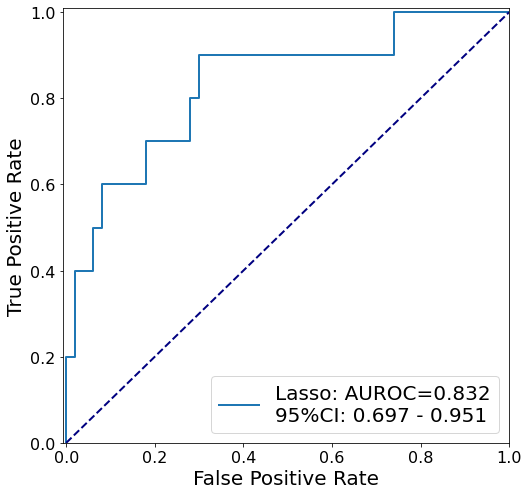

In [21]:
rng_seed=10
plot_name="GC-prognosis-model"
plt.figure(figsize=(8, 8))
fpr, tpr, _ = roc_curve(State, risk_score)
raw=roc_auc_score(State, risk_score)
r , l = CI(State, risk_score)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw,r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.008, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
#plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16)
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("../../results/GC-prognosis-model/Figures/GC-prognosis-OS-AUC.pdf".format(plot_name))
#plt.show()


In [ ]:
# Save the model
import joblib
joblib.dump(rsf_sel,'../../results/GC-prognosis-model/Saved-model/GC-prognosis-model.pkl')
GC_prognosis_model = joblib.load('../../results/GC-prognosis-model/Saved-model/GC-prognosis-model.pkl')

In [35]:
# Save risk score.
GC_prognosis_model_risk_score=pd.DataFrame({'risk_score':risk_score,'OS':time,'Sample':Xtest_sample})
GC_prognosis_model_risk_score.to_excel("../../results/GC-prognosis-model/GC-prognosis-model-risk-score.xlsx")